In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Set seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

In [2]:
# Mount GDRIVE jika menggunakan Google Collab
# from google.colab import drive
# drive.mount('/content/drive')

# PATH = '/content/drive/MyDrive/'

# Jika tidak menggunakan google collab
PATH = ''

## Read Data

In [3]:
train_data = pd.read_csv(PATH + 'train.csv')
val_data   = pd.read_csv(PATH + 'validation.csv')
test_data  = pd.read_csv(PATH + 'test.csv')

In [4]:
print('Data Training:')
train_data

Data Training:


,image_path,label
0,augmented_images\Lidah Buaya\rotated_Lidah bua...,Lidah Buaya
1,augmented_images\Pepaya\brightness_Pepaya138.jpg,Pepaya
2,Indonesian Herb Leaf Dataset 3500/Jeruk Nipis\...,Jeruk Nipis
3,augmented_images\Jambu Biji\brightness_Jambu b...,Jambu Biji
4,augmented_images\Lidah Buaya\brightness_Lidah ...,Lidah Buaya
...,...,...
3995,augmented_images\Pandan\fliped_Pandan254.jpg,Pandan
3996,Indonesian Herb Leaf Dataset 3500/Jambu Biji\J...,Jambu Biji
3997,Indonesian Herb Leaf Dataset 3500/Seledri\Sele...,Seledri
3998,augmented_images\Jambu Biji\fliped_Jambu biji2...,Jambu Biji


In [5]:
print('Data Validation:')
val_data

Data Validation:


,image_path,label
0,augmented_images\Jambu Biji\brightness_Jambu b...,Jambu Biji
1,Indonesian Herb Leaf Dataset 3500/Jeruk Nipis\...,Jeruk Nipis
2,Indonesian Herb Leaf Dataset 3500/Pepaya\Pepay...,Pepaya
3,Indonesian Herb Leaf Dataset 3500/Jeruk Nipis\...,Jeruk Nipis
4,Indonesian Herb Leaf Dataset 3500/Sirih\Sirih0...,Sirih
...,...,...
495,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
496,Indonesian Herb Leaf Dataset 3500/Lidah Buaya\...,Lidah Buaya
497,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
498,Indonesian Herb Leaf Dataset 3500/Nangka\Nangk...,Nangka


In [6]:
print('Data Testing:')
test_data

Data Testing:


,image_path,label
0,Indonesian Herb Leaf Dataset 3500/Seledri\Sele...,Seledri
1,Indonesian Herb Leaf Dataset 3500/Sirih\Sirih3...,Sirih
2,Indonesian Herb Leaf Dataset 3500/Pepaya\Pepay...,Pepaya
3,Indonesian Herb Leaf Dataset 3500/Lidah Buaya\...,Lidah Buaya
4,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
...,...,...
495,Indonesian Herb Leaf Dataset 3500/Jeruk Nipis\...,Jeruk Nipis
496,Indonesian Herb Leaf Dataset 3500/Jambu Biji\J...,Jambu Biji
497,Indonesian Herb Leaf Dataset 3500/Sirih\Sirih1...,Sirih
498,Indonesian Herb Leaf Dataset 3500/Seledri\Sele...,Seledri


In [7]:
size       = 224
batch_size = 32
class_mode = 'categorical'

# Data preprocessing
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='label',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode=class_mode,
    color_mode="rgb",
    shuffle=False

)

validation_generator = datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='label',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode=class_mode,
    color_mode="rgb",
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='label',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode=class_mode,
    color_mode="rgb",
    shuffle=False
)

Found 4000 validated image filenames belonging to 10 classes.
Found 500 validated image filenames belonging to 10 classes.
Found 500 validated image filenames belonging to 10 classes.


## InceptionV3

https://medium.com/@armielynobinguar/simple-implementation-of-inceptionv3-for-image-classification-using-tensorflow-and-keras-6557feb9bf53

In [8]:
# Load InceptionV3 with pretrained weights and exclude the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(size, size, 3))

# Freeze the base model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # Output layer with softmax activation

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
model_path = 'best_model_inceptionv3.keras'

callbacks= [ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
           EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)] 

history = model.fit(train_generator,
                    epochs=100,
                    validation_data = validation_generator,
                    batch_size=32,
                    callbacks = callbacks)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.7249 - accuracy: 0.7742
Epoch 1: val_accuracy improved from -inf to 0.90400, saving model to best_model_inceptionv3.keras
125/125 [==============================] - 107s 838ms/step - loss: 0.7249 - accuracy: 0.7742 - val_loss: 0.2893 - val_accuracy: 0.9040
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.9032
Epoch 2: val_accuracy improved from 0.90400 to 0.91800, saving model to best_model_inceptionv3.keras
125/125 [==============================] - 103s 826ms/step - loss: 0.2904 - accuracy: 0.9032 - val_loss: 0.2484 - val_accuracy: 0.9180
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9243
Epoch 3: val_accuracy improved from 0.91800 to 0.93000, saving model to best_model_inceptionv3.keras
125/125 [==============================] - 112s 897ms/step - loss: 0.2294 - accuracy: 0.9243 - val_loss: 0.2064 - val_accuracy: 0.9300
Epoc

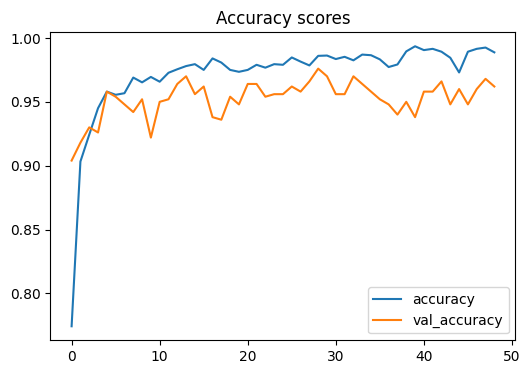

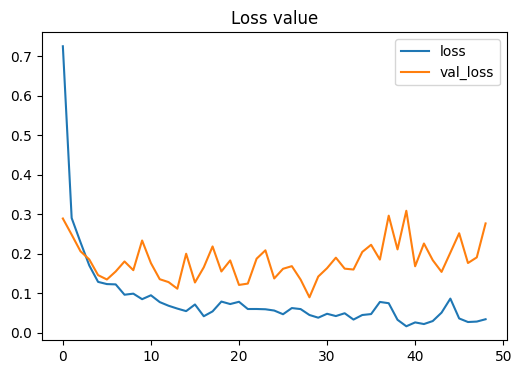

In [10]:
plt.figure(figsize=(6,4))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

plt.figure(figsize=(6,4))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Model Evaluate

In [11]:
model_path = 'best_model_inceptionv3.keras'

n_model = load_model(model_path) # Memuat model yang sudah disimpan

In [12]:
predictions = n_model.predict(test_generator)
y_pred      = np.argmax(predictions, axis=1)

16/16 [==============================] - 13s 717ms/step


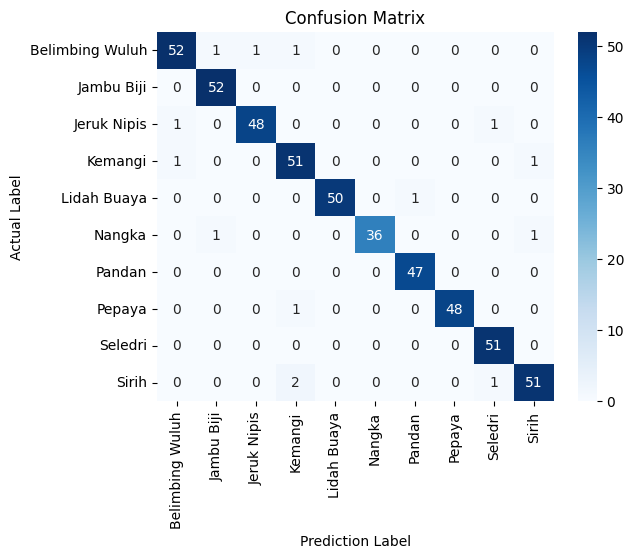

In [13]:
Confusion_matrix = confusion_matrix(test_generator.classes, y_pred)
class_label      = test_generator.class_indices.keys()
df_confusion     = pd.DataFrame(Confusion_matrix, index = class_label, columns = class_label)

sns.heatmap(df_confusion, annot=True, fmt = "d", cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Prediction Label')
plt.ylabel('Actual Label')
plt.show()

In [14]:
_accuracy   = round(accuracy_score(test_generator.classes, y_pred)*100, 2)
_precission = round(precision_score(test_generator.classes, y_pred, average='weighted')*100, 2)
_recall     = round(recall_score(test_generator.classes, y_pred, average='weighted')*100, 2)
_fscore     = round(f1_score(test_generator.classes, y_pred, average='weighted')*100, 2)

print('Accuracy   :', _accuracy, '%')
print('Precission :', _precission, '%')
print('Recall     :', _recall, '%')
print('F-Score    :', _fscore, '%')

Accuracy   : 97.2 %
Precission : 97.24 %
Recall     : 97.2 %
F-Score    : 97.2 %


In [15]:
# Ambil nama kelas
class_labels = list(test_generator.class_indices.keys())

print(classification_report(test_generator.classes, y_pred, target_names=class_labels, digits=4))

                 precision    recall  f1-score   support

Belimbing Wuluh     0.9630    0.9455    0.9541        55
     Jambu Biji     0.9630    1.0000    0.9811        52
    Jeruk Nipis     0.9796    0.9600    0.9697        50
        Kemangi     0.9273    0.9623    0.9444        53
    Lidah Buaya     1.0000    0.9804    0.9901        51
         Nangka     1.0000    0.9474    0.9730        38
         Pandan     0.9792    1.0000    0.9895        47
         Pepaya     1.0000    0.9796    0.9897        49
        Seledri     0.9623    1.0000    0.9808        51
          Sirih     0.9623    0.9444    0.9533        54

       accuracy                         0.9720       500
      macro avg     0.9736    0.9720    0.9726       500
   weighted avg     0.9724    0.9720    0.9720       500

